In [1]:
%matplotlib ipympl
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
import matplotlib.ticker as mticker

#from vizlib import *

In [2]:
filename = "/media/matt/SCRATCH/ActiveMatterWorms/data_02_02_2024/filament_data.npz"
data = np.load(filename)
pos_data = data['a']
vel_data = data['b']
N = data['a'].shape[1]
nframes = data['a'].shape[0]
print(nframes)

3001


In [3]:
def get_vector_frame(iframe,worm_length,pos_data):
    #worm_length = 80
    #iframe = -1
    num_worms = int(N/worm_length)
    print("num_worms:",num_worms)
    vector_field = np.zeros((N,6))
    worm_view = np.array_split(pos_data[iframe,:,:],num_worms)
    count = 0
    for iw in range(num_worms):
        for ip in range(len(worm_view[iw])):
            ip1 = ip + 1
            if ip == len(worm_view[iw])-1:
                ip1 = ip-1
            vec = np.zeros(3)
            pos = np.zeros(3)
            pos[0] = worm_view[iw][ip][0]
            pos[1] = worm_view[iw][ip][1]
            pos[2] = worm_view[iw][ip][2]
            vec[0] = worm_view[iw][ip][0] - worm_view[iw][ip1][0] #X
            vec[1] = worm_view[iw][ip][1] - worm_view[iw][ip1][1] #Y
            vec[2] = worm_view[iw][ip][2] - worm_view[iw][ip1][2] #Z
            n = np.sqrt(vec[0] ** 2 + vec[1] ** 2 + vec[2]**2)
            vec = vec/n
            vector_field[count,0:3] = pos
            vector_field[count,3:6] = vec
            count += 1
    return vector_field

vector_field = get_vector_frame(-1,80,pos_data)

num_worms: 800


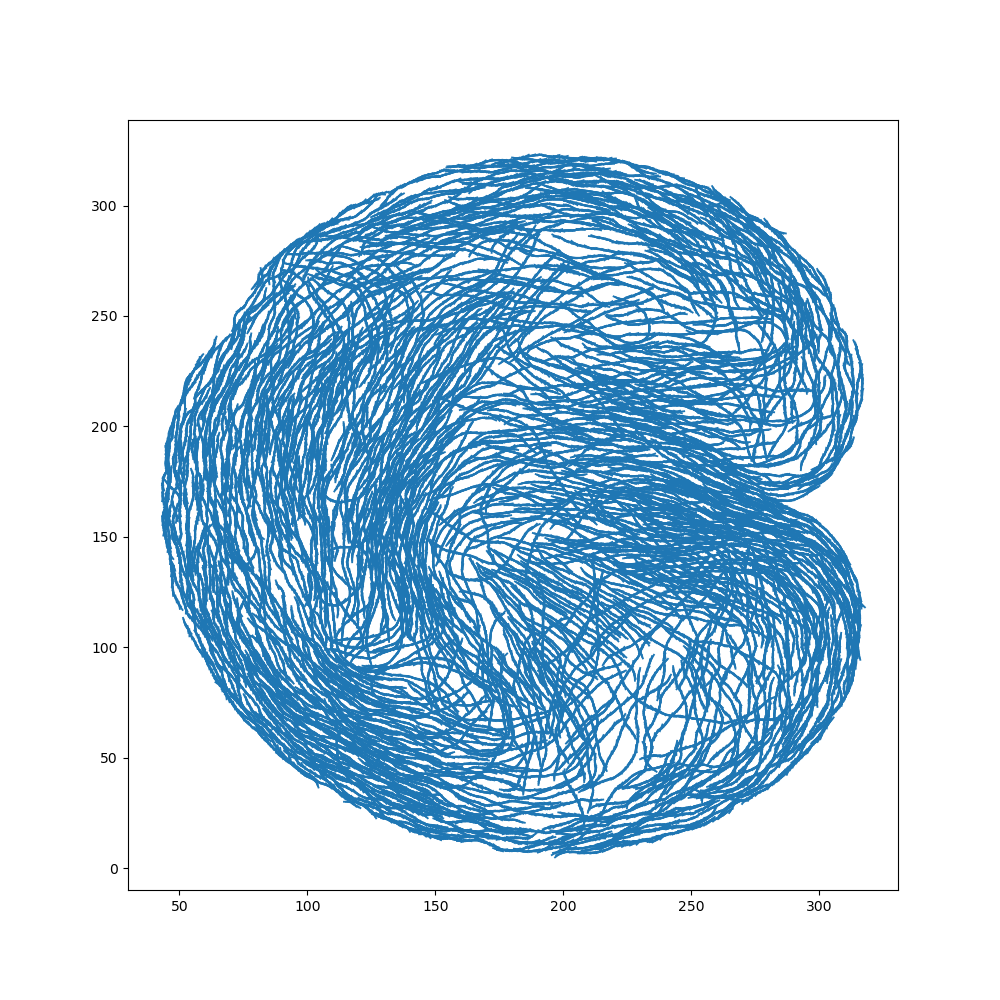

In [4]:
"""plotting the vectors of each of the individual particles"""
fig,ax = plt.subplots(1,1,figsize=(10,10))
quiver = ax.quiver(vector_field[:,0], #x
                   vector_field[:,1], #y
                   vector_field[:,3], #u
                   vector_field[:,4], #v
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()

In [5]:
def get_Q(vector_field,num_interpolation_points):
    max_x = np.max(vector_field[:,0])
    min_x = np.min(vector_field[:,0])
    max_y = np.max(vector_field[:,1])
    min_y = np.min(vector_field[:,1])
    print("X:",min_x,max_x,max_x-min_x)
    print("Y:",min_y,max_y,max_y-min_y)

    x_grid,y_grid = np.meshgrid(np.linspace(min_x,max_x,num_interpolation_points),
                                np.linspace(min_y,max_y,num_interpolation_points))

    Qxx = np.zeros((num_interpolation_points,num_interpolation_points))
    Qxy = np.zeros((num_interpolation_points,num_interpolation_points))
    for i in np.arange(0,x_grid.shape[0]-1):
        for j in np.arange(0,y_grid.shape[1]-1):
            # getting the cell boundary points
            mask = (vector_field[:,0] >= x_grid[i,j]) & (vector_field[:,0] < x_grid[i,j+1]) & \
                 (vector_field[:,1] >= y_grid[i,j]) & (vector_field[:,1] < y_grid[i+1,j])
            # selecting particles that are in that cell
            if np.any(mask):
                x_cell_vals = vector_field[mask,3]
                y_cell_vals = vector_field[mask,4]
            else:
                x_cell_vals = 0.0
                y_cell_vals = 0.0

            Qxx[i,j] = 0.5*(3*np.mean(x_cell_vals*x_cell_vals)-1)
            Qxy[i,j] = 0.5*(3*np.mean(x_cell_vals*y_cell_vals))
    np.nan_to_num(Qxx, copy=False, nan=0.0)
    np.nan_to_num(Qxy, copy=False, nan=0.0)
    return Qxx,Qxy,x_grid,y_grid

In [6]:
def get_director(Qxx,Qxy,x_grid,y_grid,num_interpolation_points):
    nx = np.zeros((num_interpolation_points,num_interpolation_points))
    ny = np.zeros((num_interpolation_points,num_interpolation_points))
    for i in np.arange(0,x_grid.shape[0]-1):
        for j in np.arange(0,y_grid.shape[1]-1):
            #S[x,y] = 0.5*np.sqrt(self.trace_Q_squared(self.Q[x,y,0],self.Q[x,y,1]))
            a = Qxx[i,j]
            b = Qxy[i,j]
            eigenvalues,eigenvectors = np.linalg.eig(np.array([[a,b],[b,-a]]))
            nx[i,j] = eigenvectors[0,np.argmax(eigenvalues)]
            ny[i,j] = eigenvectors[1,np.argmax(eigenvalues)]
    return nx,ny

X: 43.3921012878418 316.8500061035156 273.4579048156738
Y: 5.911489963531494 322.87701416015625 316.96552419662476


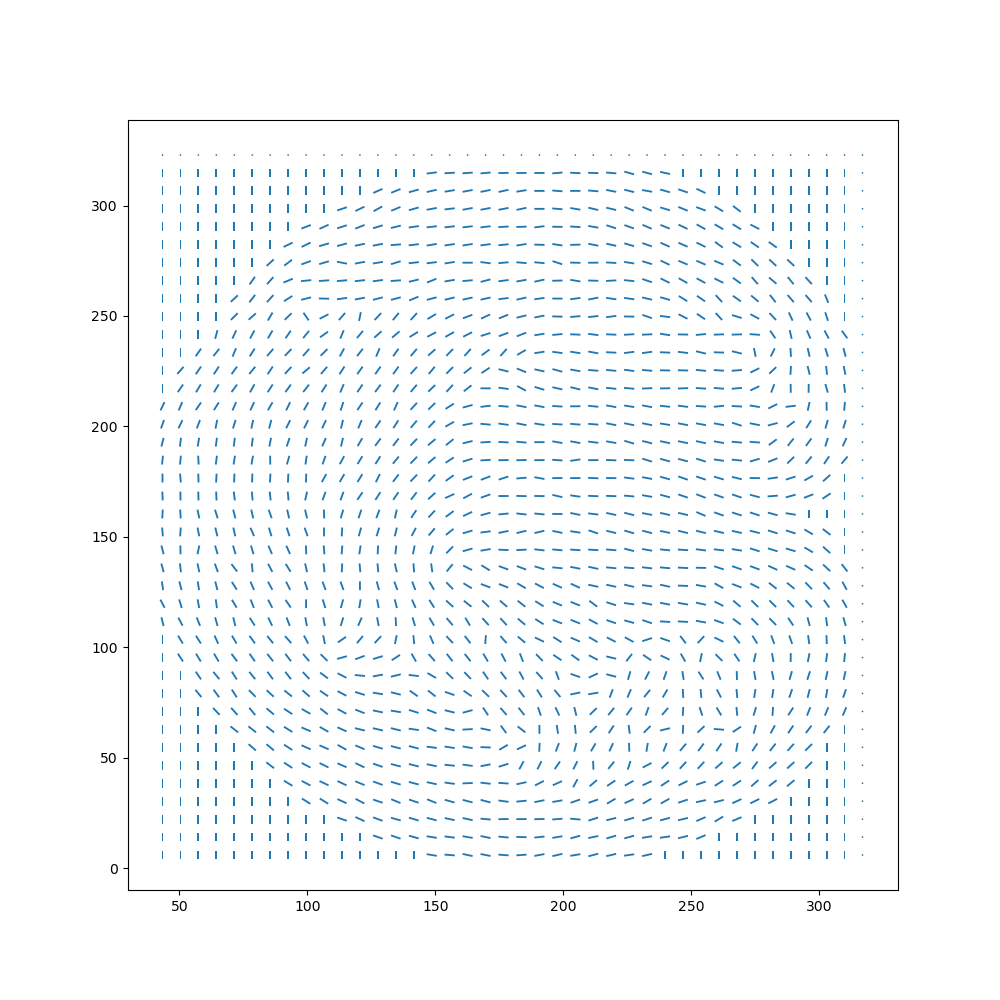

In [7]:
num_interpolation_points = 40
Qxx,Qxy,x_grid,y_grid = get_Q(vector_field,num_interpolation_points)
nx,ny = get_director(Qxx,Qxy,x_grid,y_grid,num_interpolation_points)
"""plotting the vectors of each of the individual particles"""
fig,ax = plt.subplots(1,1,figsize=(10,10))
quiver = ax.quiver(x_grid, #x
                   y_grid, #y
                   nx, #u
                   ny, #v
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
plt.show()


In [8]:
def calc_defects(Qxx,Qxy,x_grid,y_grid,normalize=True):
    dx = x_grid[0,1] - x_grid[0,0]
    dy = y_grid[1,0] - y_grid[0,0]

    dq11_tensor_dx = np.zeros_like(x_grid)
    dq12_tensor_dx = np.zeros_like(x_grid)
    dq11_tensor_dy = np.zeros_like(y_grid)
    dq12_tensor_dy = np.zeros_like(y_grid)

    dq11_tensor_dx[:, 1:-1] = (Qxx[:, 2:] - Qxx[:, :-2]) / (2 * dx)
    dq11_tensor_dx[:, 0] = (Qxx[:, 1] - Qxx[:, 0]) / dx
    dq11_tensor_dx[:, -1] = (Qxx[:, -1] - Qxx[:, -2]) / dx

    dq12_tensor_dx[:, 1:-1] = (Qxy[:, 2:] - Qxy[:, :-2]) / (2 * dx)
    dq12_tensor_dx[:, 0] = (Qxy[:, 1] - Qxy[:, 0]) / dx
    dq12_tensor_dx[:, -1] = (Qxy[:, -1] - Qxy[:, -2]) / dx

    dq11_tensor_dy[1:-1, :] = (Qxx[2:, :] - Qxx[:-2, :]) / (2 * dy)
    dq11_tensor_dy[0, :] = (Qxx[1, :] - Qxx[0, :]) / dy
    dq11_tensor_dy[-1, :] = (Qxx[-1, :] - Qxx[-2, :]) / dy

    dq12_tensor_dy[1:-1, :] = (Qxy[2:, :] - Qxy[:-2, :]) / (2 * dy)
    dq12_tensor_dy[0, :] = (Qxy[1, :] - Qxy[0, :]) / dy
    dq12_tensor_dy[-1, :] = (Qxy[-1, :] - Qxy[-2, :]) / dy

    dij = dq11_tensor_dx * dq12_tensor_dy - dq11_tensor_dy*dq12_tensor_dx
    print(dij.shape)
    #normalizing dij
    if normalize:
        dij = (dij-np.min(dij))/(np.max(dij)-np.min(dij)) - 0.5
    return dij

X: 43.3921012878418 316.8500061035156 273.4579048156738
Y: 5.911489963531494 322.87701416015625 316.96552419662476
(40, 40)


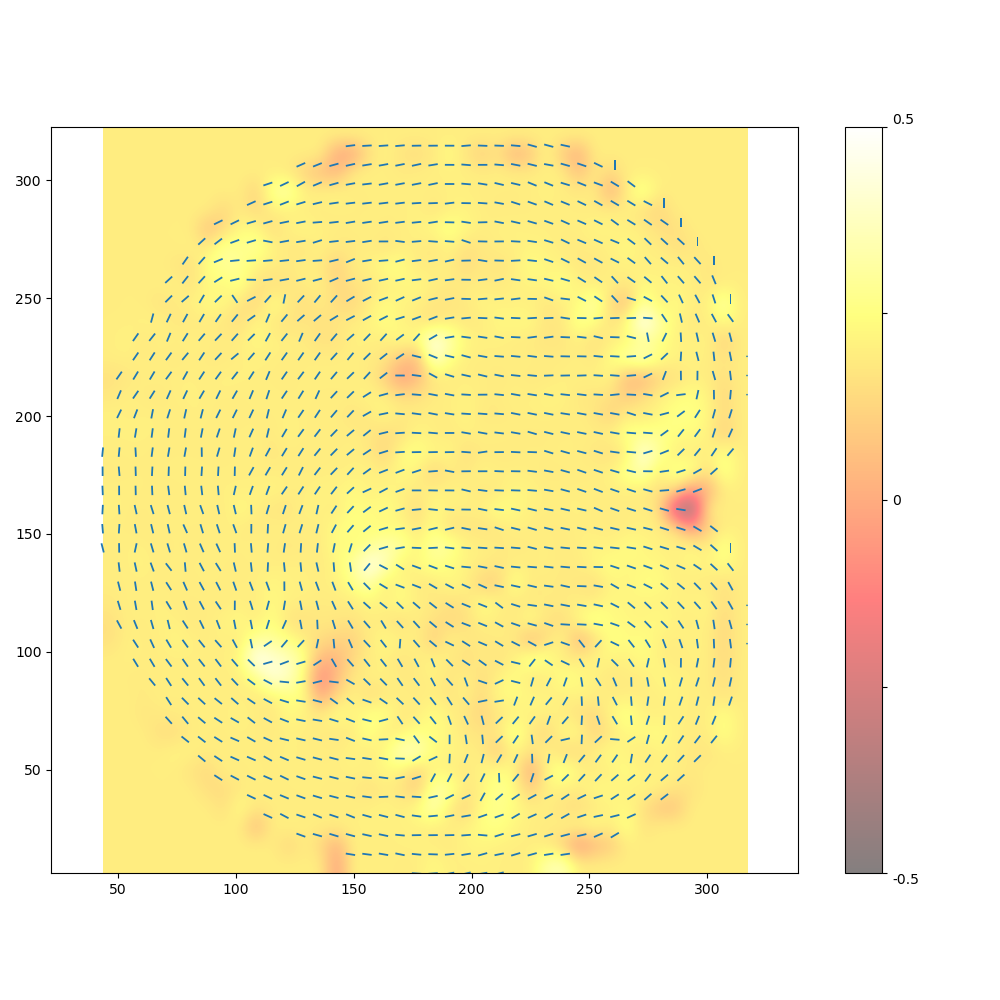

In [9]:
num_interpolation_points = 40
Qxx,Qxy,x_grid,y_grid = get_Q(vector_field,num_interpolation_points)
nx,ny = get_director(Qxx,Qxy,x_grid,y_grid,num_interpolation_points)
dij = calc_defects(Qxx,Qxy,x_grid,y_grid)

max_x = np.max(vector_field[:,0])
min_x = np.min(vector_field[:,0])
max_y = np.max(vector_field[:,1])
min_y = np.min(vector_field[:,1])
#drawing the cardioid
rwall=164
c_a = 1.5*(rwall/2)
t = np.linspace(0,2*np.pi,1000)
cx = c_a * (1 - np.cos(t)) * np.cos(t) + rwall + c_a
cy = c_a * (1 - np.cos(t)) * np.sin(t) + rwall
for i in np.arange(0,x_grid.shape[0]):
    for j in np.arange(0,y_grid.shape[1]):
        dx = x_grid[i,j] - rwall - c_a
        dy = y_grid[i,j] - rwall
        r = np.sqrt(dx*dx + dy*dy)
        c_r = 1 - np.cos(np.arctan2(dy,dx))
        if r > c_a*c_r:
            nx[i,j] = np.nan
            ny[i,j] = np.nan
            

fig,ax2 = plt.subplots(1,1,figsize=(10,10))
quiver = ax2.quiver(x_grid, #x
                   y_grid, #y
                   nx, #u
                   ny, #v
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
#ax2.plot(cx,cy,color='k')
pcm = ax2.imshow(dij,cmap="hot",interpolation="bicubic",alpha=0.5,origin="lower",extent=(min_x,max_x,min_y,max_y))
#pcm = ax2.imshow(dij,cmap="hot",alpha=0.5,origin="lower",extent=(min_x,max_x,min_y,max_y))
cbar = fig.colorbar(pcm, shrink=0.77, ax=ax2,ticks=[-0.5, -0.25, 0, 0.25, 0.5],format=mticker.FixedFormatter(['-0.5', '', '0', '', '0.5']))
labels = cbar.ax.get_yticklabels()
labels[0].set_verticalalignment('top')
labels[-1].set_verticalalignment('bottom')
ax2.set_box_aspect(1)
ax2.set_adjustable("datalim")
plt.tight_layout()
plt.show()

In [16]:
def plot_frame(iframe,pos_data):
    worm_length = 80
    vector_field = get_vector_frame(iframe,worm_length,pos_data)
    num_interpolation_points = 40
    Qxx,Qxy,x_grid,y_grid = get_Q(vector_field,num_interpolation_points)
    nx,ny = get_director(Qxx,Qxy,x_grid,y_grid,num_interpolation_points)
    dij = calc_defects(Qxx,Qxy,x_grid,y_grid)

    max_x = np.max(vector_field[:,0])
    min_x = np.min(vector_field[:,0])
    max_y = np.max(vector_field[:,1])
    min_y = np.min(vector_field[:,1])
    #drawing the cardioid
    rwall=164
    c_a = 1.5*(rwall/2)
    t = np.linspace(0,2*np.pi,1000)
    cx = c_a * (1 - np.cos(t)) * np.cos(t) + rwall + c_a
    cy = c_a * (1 - np.cos(t)) * np.sin(t) + rwall
    for i in np.arange(0,x_grid.shape[0]):
        for j in np.arange(0,y_grid.shape[1]):
            dx = x_grid[i,j] - rwall - c_a
            dy = y_grid[i,j] - rwall
            r = np.sqrt(dx*dx + dy*dy)
            c_r = 1 - np.cos(np.arctan2(dy,dx))
            if r > c_a*c_r:
                nx[i,j] = np.nan
                ny[i,j] = np.nan


    fig,ax2 = plt.subplots(1,1,figsize=(6,6))
    quiver = ax2.quiver(x_grid, #x
                       y_grid, #y
                       nx, #u
                       ny, #v
                       pivot='mid',
                       headlength=0,
                       headwidth=0,
                       headaxislength=0,
                       color="tab:blue",
                       scale_units='xy',
                       scale=0.25
    )
    #ax2.plot(cx,cy,color='k')
    pcm = ax2.imshow(dij,cmap="hot",interpolation="bicubic",alpha=0.5,origin="lower",extent=(min_x,max_x,min_y,max_y))
    #pcm = ax2.imshow(dij,cmap="hot",alpha=0.5,origin="lower",extent=(min_x,max_x,min_y,max_y))
    cbar = fig.colorbar(pcm, shrink=0.77, ax=ax2,ticks=[-0.5, -0.25, 0, 0.25, 0.5],format=mticker.FixedFormatter(['-0.5', '', '0', '', '0.5']))
    labels = cbar.ax.get_yticklabels()
    labels[0].set_verticalalignment('top')
    labels[-1].set_verticalalignment('bottom')
    ax2.set_box_aspect(1)
    ax2.set_adjustable("datalim")
    ax2.set_title(iframe)
    plt.tight_layout()
    #plt.show()

num_worms: 800
X: 42.74599838256836 316.63800048828125 273.8920021057129
Y: 6.3994598388671875 321.42999267578125 315.03053283691406
(40, 40)
num_worms: 800
X: 42.62300109863281 316.7590026855469 274.13600158691406
Y: 6.674260139465332 322.6080017089844 315.93374156951904
(40, 40)
num_worms: 800
X: 43.11579895019531 316.510986328125 273.3951873779297
Y: 5.991230010986328 322.4410095214844 316.44977951049805
(40, 40)
num_worms: 800
X: 42.935001373291016 316.2900085449219 273.35500717163086
Y: 6.621880054473877 322.70001220703125 316.0781321525574
(40, 40)
num_worms: 800
X: 42.62839889526367 316.9179992675781 274.28960037231445
Y: 6.1102399826049805 322.8420104980469 316.7317705154419
(40, 40)


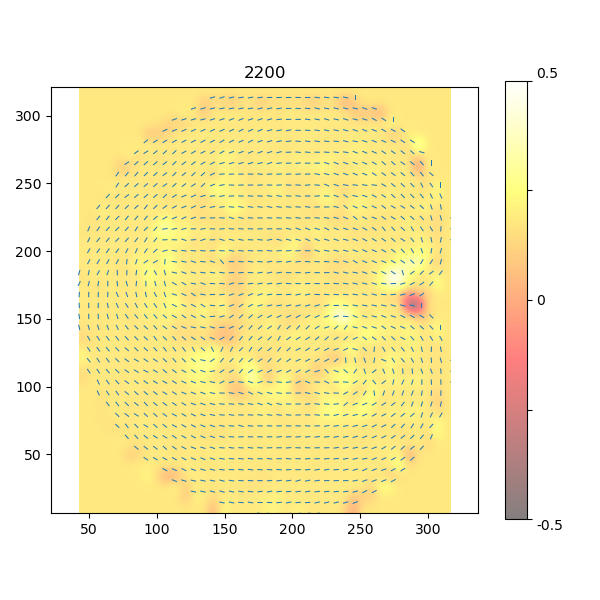

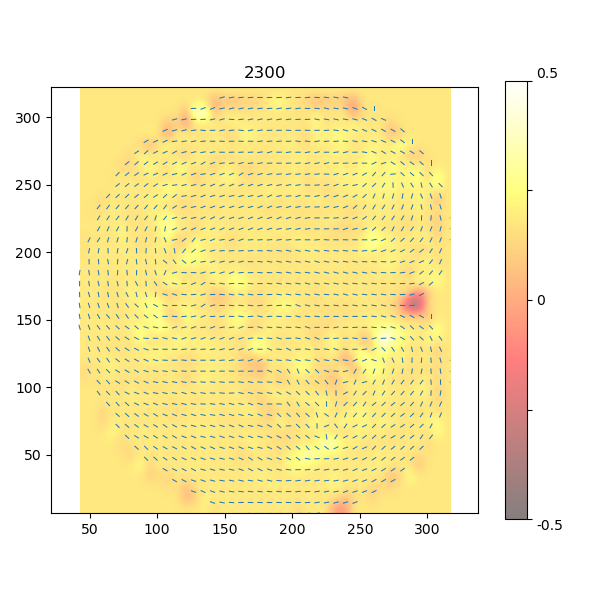

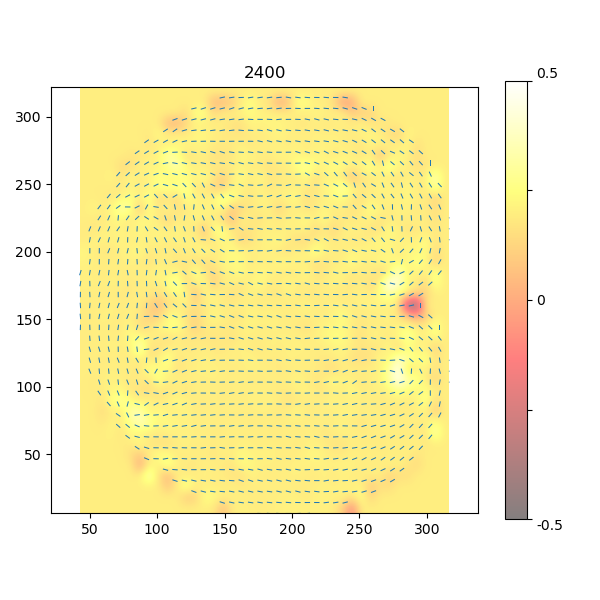

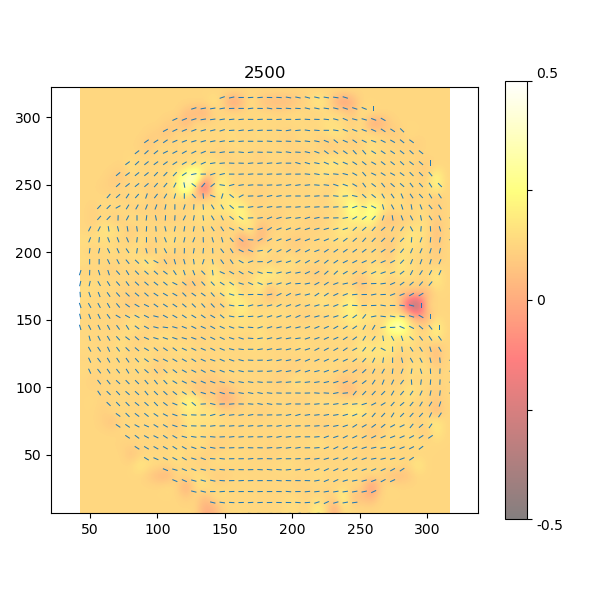

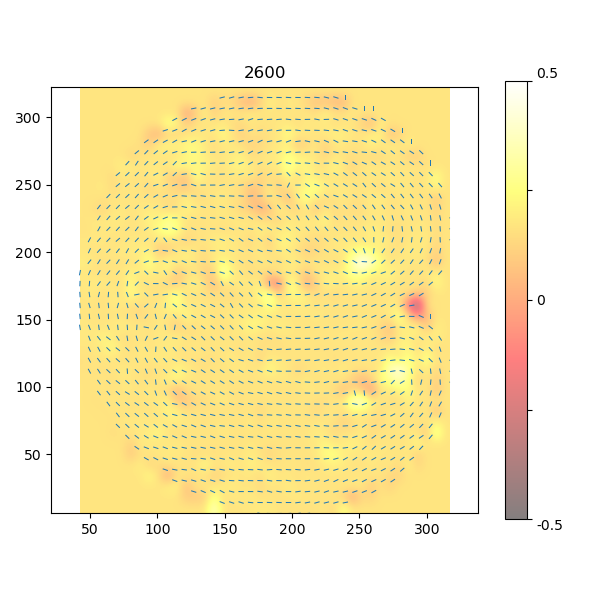

In [17]:
frames = [2200,2300,2400,2500,2600]
for iframe in frames:
    plot_frame(iframe,pos_data)

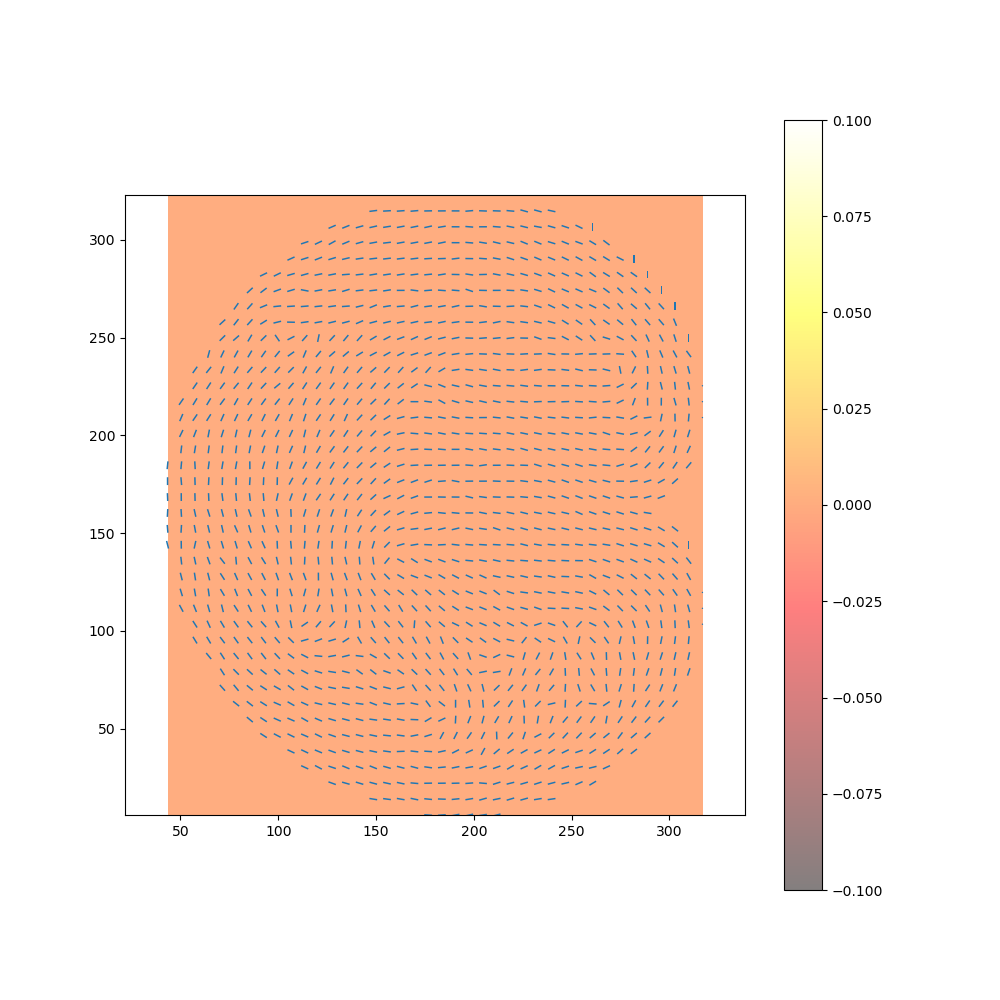

In [65]:
#beta = 1 - 6 (Tr(Q^3)^2) / (Tr(Q^2)^3)

beta = np.zeros_like(x_grid)
for i in np.arange(0,x_grid.shape[0]):
    for j in np.arange(0,y_grid.shape[1]):
        a = Qxx[i,j]
        b = Qxy[i,j]
        if (a != 0.0) or (b!= 0.0):
            Q = np.array([[a,b],[b,-a]])
            trQ3 = np.trace(Q*Q*Q)
            trQ2 = np.trace(Q*Q)
            #beta[i,j] = 1 - 6 *((trQ3*trQ3)/(trQ2*trQ2*trQ2))
            beta[i,j] = ((trQ3*trQ3)/(trQ2*trQ2*trQ2))

#drawing the cardioid
rwall=164
c_a = 1.5*(rwall/2)
t = np.linspace(0,2*np.pi,1000)
cx = c_a * (1 - np.cos(t)) * np.cos(t) + rwall + c_a
cy = c_a * (1 - np.cos(t)) * np.sin(t) + rwall
for i in np.arange(0,x_grid.shape[0]):
    for j in np.arange(0,y_grid.shape[1]):
        dx = x_grid[i,j] - rwall - c_a
        dy = y_grid[i,j] - rwall
        r = np.sqrt(dx*dx + dy*dy)
        c_r = 1 - np.cos(np.arctan2(dy,dx))
        if r > c_a*c_r:
            nx[i,j] = np.nan
            ny[i,j] = np.nan
            

fig,ax2 = plt.subplots(1,1,figsize=(10,10))
quiver = ax2.quiver(x_grid, #x
                   y_grid, #y
                   nx, #u
                   ny, #v
                   pivot='mid',
                   headlength=0,
                   headwidth=0,
                   headaxislength=0,
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
#ax2.plot(cx,cy,color='k')
#pcm = ax2.imshow(beta,cmap="hot",interpolation="bicubic",alpha=0.5,origin="lower",extent=(min_x,max_x,min_y,max_y))
pcm = ax2.imshow(beta,cmap="hot",alpha=0.5,origin="lower",extent=(min_x,max_x,min_y,max_y))
fig.colorbar(pcm, ax=ax2)
ax2.set_box_aspect(1)
ax2.set_adjustable("datalim")
plt.show()